In [85]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

import numpy as np
import tqdm

import matplotlib.pyplot as plt

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_namse = iris['feature_names']

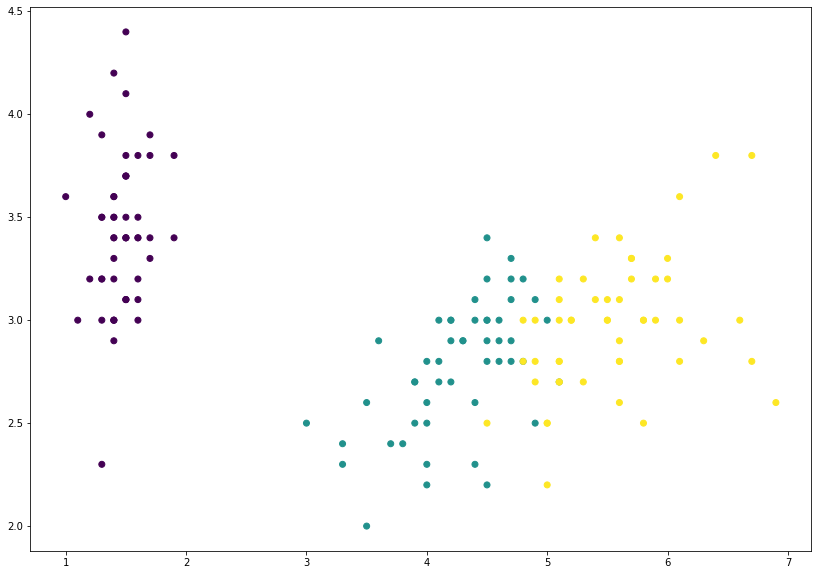

In [92]:
plt.figure(figsize=(14,10))
plt.scatter(X[:,2], X[:, 1], c=y)

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=234)

X_train = torch.FloatTensor(X_train).float()
y_train = torch.LongTensor(y_train).long()
X_test  = torch.FloatTensor(X_test).float()
y_test  = torch.LongTensor(y_test).long()

In [45]:
class ClassifierMLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnt_hidden_layers, output_dim):
        super(ClassifierMLPModel, self).__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = []
        layer_num = int(np.log2(hidden_dim))
        for i in range(min(cnt_hidden_layers, layer_num - 1)):
            f_dim = int(hidden_dim/(2**i))
            o_dim = int(hidden_dim/(2**(i + 1)))
            self.hidden.append(nn.Linear(f_dim, o_dim))
        self.output = nn.Linear(int(hidden_dim / (2**cnt_hidden_layers)), output_dim)

    def forward(self, x):
        x = self.input(x)
        x = torch.relu(x)
        for h in self.hidden:
            x = h(x)
            x = torch.relu(x)
        return self.output(x)

In [46]:
crit = nn.CrossEntropyLoss()

In [47]:
model = ClassifierMLPModel(X_train.shape[1], 24, 4, 1)
print(y_train)

tensor([0, 1, 2, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2,
        2, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1,
        2, 1, 2, 0, 2, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 0, 1,
        0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 1,
        1, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1])


In [97]:
def test_mesh():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xx, yy = np.meshgrid(x, y)
    dim = x.shape
    mesh_flat = np.array([xx.flatten(), yy.flatten(), xx.flatten(), xx.flatten()], dtype=np.float32)
    mesh_input = torch.from_numpy(mesh_flat)
    return x, y, mesh_input

In [113]:
def train(model, crit, optimizer, X_train, y_train, X_test, y_test, n_epochs = 100, epsilon=1e-3):
    history = []
    acc_list = []
    img = []
    for epoch in tqdm.trange(n_epochs):
        model.train()
        # FORWARD
        y_hat = model(X_train)
        loss = crit(y_hat, y_train)
        # BACKWARD
        optimizer.zero_grad()
        loss.backward()
        # UPDATE
        optimizer.step()
        history.append(loss.item())
        model.eval()
        with torch.no_grad():
            y_hat = model(X_test)
            total_correct = torch.sum(torch.max(y_hat, 1).indices==y_test)
            acc_list.append((total_correct/y_test.shape[0]).item())
            if epoch % 5 == 0:
                tx, ty, mesh_input = test_mesh()
                ty_hat = model(mesh_input.T)
                tz = np.reshape(torch.max(ty_hat, 1).values.numpy(), (100, 100))
                fig = plt.figure(figsize=(14,10))
                plt.contourf(tx, ty, tz)
                fig.tight_layout(pad=0)
                fig.canvas.draw()
                data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                data = data.reshape(fig.canvas.get_width_height()[::-1]+(3,))
                img.append(data)
                plt.close()
    return history, acc_list, img


In [114]:
model = ClassifierMLPModel(X_train.shape[1], 24, 3, 3)
optimizier = optim.Adam(model.parameters(), lr=0.1)
history, acc, img = train(model, crit, optimizier, X_train, y_train, X_test, y_test)

100%|██████████| 100/100 [00:02<00:00, 42.72it/s]


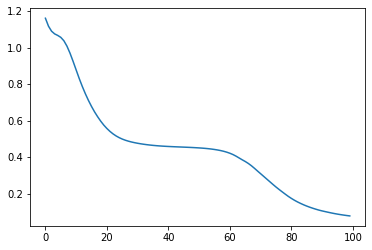

In [88]:
plt.plot(history)

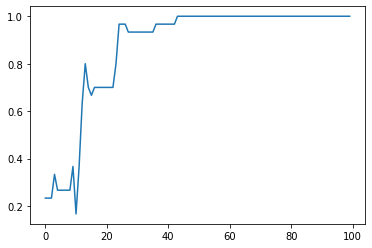

In [111]:
plt.plot(acc)

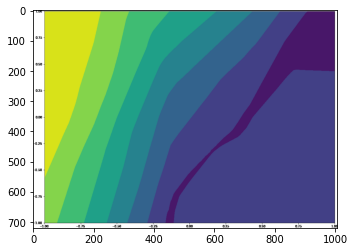

In [116]:
plt.imshow(img[0])

In [120]:
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

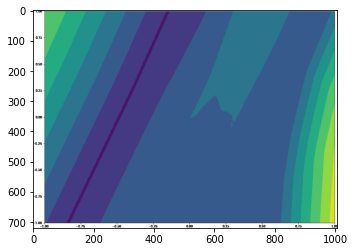

In [121]:
frames = []
fig = plt.figure()
for i in range(len(img)):
    frames.append([plt.imshow(img[i], animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani